In [63]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [64]:
pip install pymorphy2

Note: you may need to restart the kernel to use updated packages.


In [65]:
import gc
import nltk
import torch
import pymorphy2
import itertools
import numpy as np
import pandas as pd
import torchmetrics
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch import nn, optim
from nltk import word_tokenize
from collections import Counter
from IPython.display import display
from gensim.models import KeyedVectors
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from torch.nn.utils.rnn import pad_sequence
from pytorch_lightning import LightningModule
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import Trainer as LightningTrainer
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

morph = pymorphy2.MorphAnalyzer()
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [66]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = 'cpu'
print(DEVICE)

cuda


## Данные и препроцессинг

In [67]:
df = pd.read_csv('../input/fake-and-real-news-dataset/Fake.csv')
df.drop_duplicates(inplace=True)
df.head(5)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [68]:
print(len(df))
print(df['subject'].unique())

23478
['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']


<AxesSubplot:ylabel='subject'>

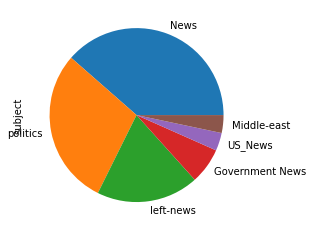

In [69]:
df['subject'].value_counts().plot(kind='pie')

В оригинальной статье на этапе предобработки тексты только приводили к нижнему регистру, поэтому я делаю то же самое, но в виде функции, чтобы в будущем можно было легко что-то поменять

In [70]:
def preprocess(text):
    return word_tokenize(text.lower())

In [71]:
df['text_prep'] = df['text'].apply(preprocess)

<AxesSubplot:ylabel='Frequency'>

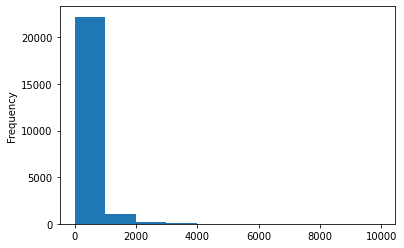

In [72]:
df['text_prep'].str.len().plot(kind='hist')

Почти все тексты находятся в диапазоне до 1к токенов, ещё несколько до 4к. Я буду обрезать тексты до 500 токенов, чтобы уменьшить размер данных и увеличить скорость выполнения (иначе это займёт много-много часов при всех возможных переборах гиперпараметров)

In [73]:
df['text_prep'] = df['text_prep'].apply(lambda x: x[:500])

<AxesSubplot:ylabel='Frequency'>

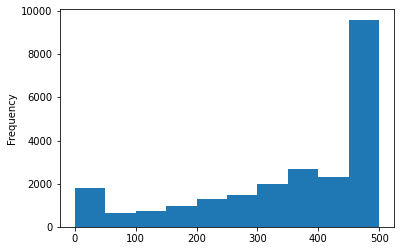

In [74]:
df['text_prep'].str.len().plot(kind='hist')

In [75]:
vocab = Counter()
for tokenlist in df['text_prep']:
    vocab.update(tokenlist)
print('всего уникальных слов:', len(vocab))

всего уникальных слов: 151903


In [76]:
# словарь
word2id = {'PAD':0}
for word in vocab:
    word2id[word] = len(word2id)
#обратный словарь
id2word = {i:word for word, i in word2id.items()}

In [77]:
topic_mapper = {topic: t for t, topic in enumerate(df['subject'].unique())}
topic_mapper

{'News': 0,
 'politics': 1,
 'Government News': 2,
 'left-news': 3,
 'US_News': 4,
 'Middle-east': 5}

In [78]:
df['target'] = df['subject'].map(topic_mapper)
df.head(5)

,title,text,subject,date,text_prep,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017","[donald, trump, just, couldn, t, wish, all, am...",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017","[house, intelligence, committee, chairman, dev...",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017","[on, friday, ,, it, was, revealed, that, forme...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017","[on, christmas, day, ,, donald, trump, announc...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017","[pope, francis, used, his, annual, christmas, ...",0


In [79]:
train, test = train_test_split(df[['text_prep', 'target']], test_size=0.2)

In [80]:
# максимальная длина новости из трейна,
# до которой будет падиться трейн и обрезаться тест
maxlen = max(train['text_prep'].str.len())
maxlen

500

## DataSet

In [81]:
class NewsDataset(Dataset):

    def __init__(self, df, word2id, maxlen, DEVICE, pad_token='PAD'):
        self.dataset = df['text_prep'].values
        self.word2id = word2id
        self.length = df.shape[0]
        self.target = df['target'].values
        self.device = DEVICE
        self.maxlen = maxlen
        self.pad_token = pad_token

    def __len__(self):
        return self.length

    def padding(self, tokenlist):
        if len(tokenlist) < self.maxlen:
            add_pad = self.maxlen - len(tokenlist)
            return [self.pad_token] * add_pad + tokenlist
        else:
            return tokenlist[:self.maxlen]

    def __getitem__(self, index): 
        words = self.padding(self.dataset[index])
        ids = torch.LongTensor([self.word2id[word] for word in words if word in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
        ids, y = list(zip(*batch))
        ids = torch.stack(ids).type(torch.LongTensor).to(self.device)
        y = torch.LongTensor(y).flatten().to(self.device)
        return ids, y

In [82]:
train_dataset = NewsDataset(train, word2id, maxlen, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=64)

In [83]:
test_dataset = NewsDataset(test, word2id, maxlen, DEVICE)
test_sampler = RandomSampler(test_dataset)
test_iterator = DataLoader(test_dataset, collate_fn = test_dataset.collate_fn, sampler=test_sampler, batch_size=64)

In [84]:
x, y = next(iter(train_iterator))
print(' '.join([id2word[int(i)] for i in x[0]]))
print(y[0])

PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 

## Загрузка предобученных векторов

In [85]:
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

--2021-12-20 10:11:58--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.78.54
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.78.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz.2’

GoogleNews-vectors- 100%[===================>]   1.53G  40.4MB/s    in 34s     

2021-12-20 10:12:32 (46.6 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz.2’ saved [1647046227/1647046227]



In [86]:
w2v = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [87]:
# собрать матрицу векторов в нужном порядке
vectors = []
for word in word2id:
    lemma = morph.parse(word)[0].normal_form
    if lemma in w2v:
        vectors.append(w2v.get_vector(lemma))
    #elif word == 'PAD':
    #    vectors.append(np.random.uniform(-0.25, 0.25, 300))
    else:
        vectors.append(np.random.uniform(-0.25, 0.25, 300))

weights = torch.tensor(vectors)
weights.shape

torch.Size([151904, 300])

In [88]:
del w2v

In [89]:
weights = weights.to(torch.float).to(DEVICE)
weights.shape

torch.Size([151904, 300])

## Класс модели C-LSTM

In [90]:
class C_LSTM(LightningModule):
    def __init__(self, vocab_size, n_filters, filter_size, layer_dropout, weights):
        super().__init__()
        self.n_filters = n_filters
        self.filter_size = filter_size
        self.layer_dropout = layer_dropout
        self.lstm_size = self.n_filters
        self.num_layers = 1
        self.embedding_dim = weights.shape[1]
        self.dropout = nn.Dropout(p=0.5)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy()
        
        self.embedding = nn.Embedding.from_pretrained(weights, freeze=False)
        
        self.conv_layers = nn.ModuleList([])
        for size in self.filter_size:
            conv = nn.Conv1d(in_channels=self.embedding_dim, out_channels=self.n_filters,
                             kernel_size=size, padding='valid')
            self.conv_layers.append(conv)

        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=self.n_filters * len(filter_size),
                            hidden_size=self.lstm_size,
                            num_layers=self.num_layers,
                            batch_first=True)
        self.out = nn.Linear(in_features=self.lstm_size, out_features=6)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, text, prev_state=None):
        if self.layer_dropout == 'CNN':
            embed = self.dropout(self.embedding(text))
        else:
            embed = self.embedding(text)
        embed = embed.transpose(1,2)

        if len(self.conv_layers) == 1:
            conv = self.conv_layers[0]
            conv_layer = self.relu(conv(embed))
            # batch_size x filter_count3 x seq_len
        elif len(self.conv_layers) > 1:
            conv_outputs = []
            for conv in self.conv_layers:                
                conv_layer = self.relu(conv(embed))
                # здесь обрезка до мин длины по формуле seq_len + max(filter_size) - 1
                conv_outputs.append(conv_layer[:,:,:embed.shape[-1]-max(self.filter_size)+1])
            conv_layer = torch.cat(conv_outputs, 1)
        conv_layer = conv_layer.transpose(1,2)
        # batch_size x seq_len x filter_count3

        output, (hidden, cell) = self.lstm(conv_layer)
        hidden.squeeze_(0)
        if self.layer_dropout == 'LSTM':
            hidden = self.dropout(hidden)
        logits = self.softmax(self.out(hidden))
        return logits
    
    def training_step(self, batch, batch_nb):
        x, y = batch
        pred_y = self(x)
        train_loss = self.criterion(pred_y, y)
        train_acc = self.accuracy(pred_y, y)
        self.log("train_loss", train_loss, prog_bar=True)
        return train_loss

    def validation_step(self, batch, batch_nb):
        x, y = batch
        pred_y = self(x)
        val_loss = self.criterion(pred_y, y)
        val_acc = self.accuracy(pred_y, y)
        self.log("val_loss", val_loss, prog_bar=True, logger=True)
        self.log("val_accuracy", val_acc, on_epoch=True, prog_bar=True, logger=True)
    
    def configure_optimizers(self):
        optimizer = torch.optim.RMSprop(params=self.parameters(), lr=0.001,
                                        weight_decay=0.001)
        return [optimizer]

In [91]:
m = nn.Softmax(dim=1)
input = torch.randn(2, 3)
output = m(input)
output

tensor([[0.0685, 0.5387, 0.3928],
        [0.4016, 0.3157, 0.2827]])

In [92]:
model = C_LSTM(vocab_size=len(word2id), n_filters=150, filter_size=[3,4], layer_dropout='CNN', weights=weights)

In [93]:
model

C_LSTM(
  (dropout): Dropout(p=0.5, inplace=False)
  (criterion): CrossEntropyLoss()
  (accuracy): Accuracy()
  (embedding): Embedding(151904, 300)
  (conv_layers): ModuleList(
    (0): Conv1d(300, 150, kernel_size=(3,), stride=(1,), padding=valid)
    (1): Conv1d(300, 150, kernel_size=(4,), stride=(1,), padding=valid)
  )
  (relu): ReLU()
  (lstm): LSTM(300, 150, batch_first=True)
  (out): Linear(in_features=150, out_features=6, bias=True)
  (softmax): Softmax(dim=1)
)

In [97]:
model.to(DEVICE)

C_LSTM(
  (dropout): Dropout(p=0.5, inplace=False)
  (criterion): CrossEntropyLoss()
  (accuracy): Accuracy()
  (embedding): Embedding(151904, 300)
  (conv_layers): ModuleList(
    (0): Conv1d(300, 150, kernel_size=(3,), stride=(1,), padding=valid)
    (1): Conv1d(300, 150, kernel_size=(4,), stride=(1,), padding=valid)
  )
  (relu): ReLU()
  (lstm): LSTM(300, 150, batch_first=True)
  (out): Linear(in_features=150, out_features=6, bias=True)
  (softmax): Softmax(dim=1)
)

In [98]:
x, y = next(iter(test_iterator))

In [100]:
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=0,
    verbose=True,
    mode="min"
)

ltrainer = LightningTrainer(
    gpus=1,
    max_epochs=2,
    # val_check_interval=1,
    # gradient_clip_val=5.0,
    logger=True,
    callbacks=[early_stop_callback]
)
ltrainer.fit(model, train_iterator, test_iterator)

ltrainer.validate(model, dataloaders=test_iterator)

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:373: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  f"Your {mode}_dataloader has `shuffle=True`, it is best practice to turn"


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_accuracy': 0.5864565372467041, 'val_loss': 1.4566047191619873}
--------------------------------------------------------------------------------


[{'val_loss': 1.4566047191619873, 'val_accuracy': 0.5864565372467041}]

## Обёртка в класс эксперимента

Что в модели постоянного:
* препроцессинг - приведение к нижнему регистру
* векторизация w2v Google News Dataset
  * эмбеддинги не замораживаются
  * вектора незнакомых слов -  uniform distribution [-0.25, 0.25]
* паддинг трейна до максимальной длины, паддинг или обрезка теста до максимальной длины трейна
* сначала СNN
  * с ReLU
  * без пулинга
* затем один LSTM слой
* выход из CNN трансформируется и передаётся в LSTM
* L2 регуляризация с фактором 0.001 в софтмаксе
* дропаут p=0.5
* лосс - кросс-энтропия
* оптимайзер - RMSprop 


Что меняется:
* дропаут: или на вектора перед CNN, или на выход из LSTM перед софтмаксом
* размер фильтра свёртки: 2, 3, 4, 2+3, 2+4, 3+4, 2+3+4
* количество фильтров свёртки: один с одной длиной или несколько с фильтрами разных размеров
* количество фильтров свёртки и память LSTM: 150 и 150 или 300 и 300 (или для каждого из пары ещё нужен грид сёрч? но не указано, среди чего искали)

In [101]:
class Experiment:
    def __init__(self,  epochs, n_filters=150, filter_size=[3], layer_dropout='CNN'):
        'все параметры потенциально изменяемые'
        self.params = {'n_filters': n_filters,
                       'filter_size': filter_size,
                       'layer_dropout': layer_dropout}
        self.epochs = epochs

    @staticmethod
    def report(model_accuracies, report_params):
        'вывести сравнительную табл значений аккураси'
        res_df = pd.DataFrame(report_params)
        res_df['accuracy'] = model_accuracies
        print(f"\nЛучшая модель №{res_df['accuracy'].idxmax()} с точностью {res_df['accuracy'][res_df['accuracy'].idxmax()]}")
        display(res_df.style.highlight_max('accuracy'))

    def start(self):
        'перебрать параметры и запустить обучение'
        all_model_accuracies = []
        keys = list(self.params)
        report_params = []
        print(f'Получится экспериментов: {len(list(itertools.product(*map(self.params.get, keys))))}')
        
        #early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.01,patience=0,
                                           # verbose=True, mode="min")
        for i, values in enumerate(itertools.product(*map(self.params.get, keys))):
            print(f'\nЭксперимент {i+1}\nПараметры: {dict(zip(keys, values))}')
            report_params.append(dict(zip(keys, values)))
            
            model = C_LSTM(vocab_size=len(word2id), weights=weights,
                           **dict(zip(keys, values))).to(DEVICE)
            
            trainer = LightningTrainer(gpus=1, max_epochs=self.epochs, logger=True)#,
                                        #callbacks=[early_stop_callback])
            trainer.fit(model, train_iterator, test_iterator)
            results = trainer.validate(model, dataloaders=test_iterator)
            model_accuracy = results[0]['val_accuracy']
                                        
            all_model_accuracies.append(model_accuracy)
            gc.collect()
            print(f'Model accuracy: {model_accuracy}')
    
        self.report(all_model_accuracies, report_params)

In [102]:
exp_1 = Experiment(epochs=3, n_filters=[150],
                  filter_size=[[4]], layer_dropout=['LSTM'])
# полный вариант - займёт много часов
exp_full = Experiment(epochs=10, n_filters=[150], # ещё можно 300, но тогда на 19/28 экспе кончается память,
                     filter_size=[[2],[3],[4],[2,3],[3,4],[2,4],[2,3,4]], layer_dropout=['CNN', 'LSTM'])

In [103]:
exp_full.start()

Получится экспериментов: 14

Эксперимент 1
Параметры: {'n_filters': 150, 'filter_size': [2], 'layer_dropout': 'CNN'}


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_accuracy': 0.6128619909286499, 'val_loss': 1.4272595643997192}
--------------------------------------------------------------------------------
Model accuracy: 0.6128619909286499

Эксперимент 2
Параметры: {'n_filters': 150, 'filter_size': [2], 'layer_dropout': 'LSTM'}


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_accuracy': 0.574744462966919, 'val_loss': 1.4626768827438354}
--------------------------------------------------------------------------------
Model accuracy: 0.574744462966919

Эксперимент 3
Параметры: {'n_filters': 150, 'filter_size': [3], 'layer_dropout': 'CNN'}


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_accuracy': 0.5811328887939453, 'val_loss': 1.456353783607483}
--------------------------------------------------------------------------------
Model accuracy: 0.5811328887939453

Эксперимент 4
Параметры: {'n_filters': 150, 'filter_size': [3], 'layer_dropout': 'LSTM'}


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_accuracy': 0.588798999786377, 'val_loss': 1.4506399631500244}
--------------------------------------------------------------------------------
Model accuracy: 0.588798999786377

Эксперимент 5
Параметры: {'n_filters': 150, 'filter_size': [4], 'layer_dropout': 'CNN'}


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_accuracy': 0.6173338890075684, 'val_loss': 1.420207142829895}
--------------------------------------------------------------------------------
Model accuracy: 0.6173338890075684

Эксперимент 6
Параметры: {'n_filters': 150, 'filter_size': [4], 'layer_dropout': 'LSTM'}


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_accuracy': 0.5994463562965393, 'val_loss': 1.4416855573654175}
--------------------------------------------------------------------------------
Model accuracy: 0.5994463562965393

Эксперимент 7
Параметры: {'n_filters': 150, 'filter_size': [2, 3], 'layer_dropout': 'CNN'}


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_accuracy': 0.5945485234260559, 'val_loss': 1.441756010055542}
--------------------------------------------------------------------------------
Model accuracy: 0.5945485234260559

Эксперимент 8
Параметры: {'n_filters': 150, 'filter_size': [2, 3], 'layer_dropout': 'LSTM'}


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_accuracy': 0.6017887592315674, 'val_loss': 1.4356597661972046}
--------------------------------------------------------------------------------
Model accuracy: 0.6017887592315674

Эксперимент 9
Параметры: {'n_filters': 150, 'filter_size': [3, 4], 'layer_dropout': 'CNN'}


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_accuracy': 0.5804940462112427, 'val_loss': 1.4551981687545776}
--------------------------------------------------------------------------------
Model accuracy: 0.5804940462112427

Эксперимент 10
Параметры: {'n_filters': 150, 'filter_size': [3, 4], 'layer_dropout': 'LSTM'}


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_accuracy': 0.6100937128067017, 'val_loss': 1.4329217672348022}
--------------------------------------------------------------------------------
Model accuracy: 0.6100937128067017

Эксперимент 11
Параметры: {'n_filters': 150, 'filter_size': [2, 4], 'layer_dropout': 'CNN'}


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_accuracy': 0.5988075137138367, 'val_loss': 1.440671682357788}
--------------------------------------------------------------------------------
Model accuracy: 0.5988075137138367

Эксперимент 12
Параметры: {'n_filters': 150, 'filter_size': [2, 4], 'layer_dropout': 'LSTM'}


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_accuracy': 0.5807070136070251, 'val_loss': 1.4565058946609497}
--------------------------------------------------------------------------------
Model accuracy: 0.5807070136070251

Эксперимент 13
Параметры: {'n_filters': 150, 'filter_size': [2, 3, 4], 'layer_dropout': 'CNN'}


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_accuracy': 0.6043441295623779, 'val_loss': 1.4341850280761719}
--------------------------------------------------------------------------------
Model accuracy: 0.6043441295623779

Эксперимент 14
Параметры: {'n_filters': 150, 'filter_size': [2, 3, 4], 'layer_dropout': 'LSTM'}


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_accuracy': 0.5547274351119995, 'val_loss': 1.4801065921783447}
--------------------------------------------------------------------------------
Model accuracy: 0.5547274351119995

Лучшая модель №4 с точностью 0.6173338890075684


,n_filters,filter_size,layer_dropout,accuracy
0,150,[2],CNN,0.612862
1,150,[2],LSTM,0.574744
2,150,[3],CNN,0.581133
3,150,[3],LSTM,0.588799
4,150,[4],CNN,0.617334
5,150,[4],LSTM,0.599446
6,150,"[2, 3]",CNN,0.594549
7,150,"[2, 3]",LSTM,0.601789
8,150,"[3, 4]",CNN,0.580494
9,150,"[3, 4]",LSTM,0.610094
